<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/06_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∂àÎü¨Ïò§Í∏∞

In [1]:
!pip install torchinfo

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import cv2
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset, WeightedRandomSampler
from torchvision.transforms import v2
import torchvision.models as models
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import math
from tqdm import tqdm  # ÏßÑÌñâ ÏÉÅÌô©ÏùÑ ÌëúÏãúÌïòÍ∏∞ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨
from collections import Counter
from torchinfo import summary
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
import seaborn as sns
from IPython.display import display
import pandas as pd
from torch.amp import autocast, GradScaler

# 0. ÎØ∏ÏÖò ÏÑ§Î™Ö
## ÎØ∏ÏÖò ÏÜåÍ∞ú
Ïù¥Î≤à ÎØ∏ÏÖòÏóêÏÑúÎäî ÌùâÎ∂Ä X-Ray ÏÇ¨ÏßÑÏùÑ Î∞îÌÉïÏúºÎ°ú ÌèêÎ†¥ ÌôòÏûêÎ•º Íµ¨Î∂ÑÌïòÎäî ÏûëÏóÖÏùÑ ÏàòÌñâÌï©ÎãàÎã§. Ïù¥Î≤à ÎØ∏ÏÖòÏùò Î™©ÌëúÎäî X-Ray ÏÇ¨ÏßÑÏùÑ ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ ÌèêÎ†¥ Ïó¨Î∂ÄÎ•º Íµ¨Î∂ÑÌïòÎäî Î∂ÑÎ•ò(Classification) Î™®Îç∏ÏùÑ ÎßåÎìúÎäî Í≤ÉÏûÖÎãàÎã§. ÏïÑÎûò Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÌôúÏö©ÌïòÏó¨ Îã§ÏñëÌïú Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï¶ùÍ∞ï Í∏∞Î≤ïÍ≥º Transfer LearningÍ≥º Fine-Tuning Í∏∞Î≤ïÏùÑ Ïã§ÌóòÌï¥Î≥¥Í≥†, Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï¥ Î≥¥ÏÑ∏Ïöî.

## Îç∞Ïù¥ÌÑ∞ ÏÜåÍ∞ú
- Îç∞Ïù¥ÌÑ∞ ÎßÅÌÅ¨(Chest X-Ray Images (Pneumonia))
- train: ÌõàÎ†® Îç∞Ïù¥ÌÑ∞
- test: ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞
- val: Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Í≤ÄÌÜ†

In [2]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("Ïò®ÎùºÏù∏ Colab ÌôòÍ≤Ω(Google ÏÑúÎ≤Ñ)")
else:
    check_google_colab = False
    print("Î°úÏª¨ Îü∞ÌÉÄÏûÑ ÌôòÍ≤Ω")

Î°úÏª¨ Îü∞ÌÉÄÏûÑ ÌôòÍ≤Ω


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    sub_path = "/content/drive/MyDrive/Colab Notebooks/·Ñè·Ö©·ÑÉ·Ö≥·Ñã·Öµ·Ü∫·Ñâ·Ö≥·Ñë·Ö≥·ÑÖ·Öµ·Ü´·Ñê·Ö≥·Ñå·Ö°·ÑÖ·Ö≠/·ÑÜ·Öµ·Ñâ·Öß·Ü´/·ÑÜ·Öµ·Ñâ·Öß·Ü´DATA/·ÑÜ·Öµ·Ñâ·Öß·Ü´6DATA"
    print("Google Colab ÌôòÍ≤ΩÏûÖÎãàÎã§.")
except ModuleNotFoundError:
    check_google_colab = False
    sub_path = "C:/Users/User/Google Drive Ïä§Ìä∏Î¶¨Î∞ç/ÎÇ¥ ÎìúÎùºÏù¥Î∏å/Colab Notebooks/ÏΩîÎìúÏûáÏä§ÌîÑÎ¶∞Ìä∏ÏûêÎ£å/ÎØ∏ÏÖò/ÎØ∏ÏÖòDATA/ÎØ∏ÏÖò6DATA"
    print("Local ÌôòÍ≤ΩÏûÖÎãàÎã§.")

Local ÌôòÍ≤ΩÏûÖÎãàÎã§.


In [4]:
# Ìè¥Îçî Í≤ΩÎ°ú ÏÑ§Ï†ï
if check_google_colab:
    train_dir = sub_path+"/train"
    val_dir = sub_path+"/val"
    test_dir = sub_path+"/test"
else:
    train_dir = sub_path+"/train"
    val_dir = sub_path+"/val"
    test_dir = sub_path+"/test"

print(train_dir)

C:/Users/User/Google Drive Ïä§Ìä∏Î¶¨Î∞ç/ÎÇ¥ ÎìúÎùºÏù¥Î∏å/Colab Notebooks/ÏΩîÎìúÏûáÏä§ÌîÑÎ¶∞Ìä∏ÏûêÎ£å/ÎØ∏ÏÖò/ÎØ∏ÏÖòDATA/ÎØ∏ÏÖò6DATA/train


In [5]:
# num_workers ÏÑ§Ï†ïÏùÑ ÏúÑÌï¥ ÌÅ¥ÎûòÏä§ Î™®ÎìàÌôî Î∂àÎü¨Ïò§Í∏∞
if sub_path not in sys.path:
    sys.path.append(sub_path)
    print(f"Í≤ΩÎ°ú Ï∂îÍ∞Ä: {sub_path}")

try:
    from xray_sampler_TransformDataset import TransformDataset
    print(f"Î™®Îìà ÏûÑÌè¨Ìä∏ ÏÑ±Í≥µ")
except ImportError as e:
    print(f"Î™®Îìà ÏûÑÌè¨Ìä∏ Ï§ë Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: {e}")
    print(f"Í≤ΩÎ°úÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî: {sub_path}")

Í≤ΩÎ°ú Ï∂îÍ∞Ä: C:/Users/User/Google Drive Ïä§Ìä∏Î¶¨Î∞ç/ÎÇ¥ ÎìúÎùºÏù¥Î∏å/Colab Notebooks/ÏΩîÎìúÏûáÏä§ÌîÑÎ¶∞Ìä∏ÏûêÎ£å/ÎØ∏ÏÖò/ÎØ∏ÏÖòDATA/ÎØ∏ÏÖò6DATA
Î™®Îìà ÏûÑÌè¨Ìä∏ ÏÑ±Í≥µ


 - Í∞Å Ìè¥ÎçîÎ≥ÑÎ°ú Ïù¥ÎØ∏ÏßÄ Í∞ØÏàòÏôÄ ÏµúÎåÄ ÏµúÏÜå ÏÇ¨Ïù¥Ï¶à, Ï±ÑÎÑê ÏàòÎ•º ÌôïÏù∏Ìï©ÎãàÎã§.

### Ï†ÑÏ≤òÎ¶¨ ÌôïÏù∏Ïö© ÏÖÄ. Í≤∞Í≥º ÌôïÏù∏ ÌõÑ Ï£ºÏÑù Ï≤òÎ¶¨

In [6]:
# #### Í≤∞Í≥º ÌôïÏù∏ ÌõÑ Ï£ºÏÑùÏ≤òÎ¶¨
# def summarize_image_sizes(root_folder):
#     summary = {}

#     for label_folder in os.listdir(root_folder):
#         folder_path = os.path.join(root_folder, label_folder)
#         if not os.path.isdir(folder_path):
#             continue

#         img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpeg")]
#         if not img_files:
#             continue

#         heights, widths, ratios, channels = [], [], [], []
#         for f in img_files:
#             img_path = os.path.join(folder_path, f)
#             img_data = np.fromfile(img_path, dtype=np.uint8)
#             img = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
#             if img is None:
#                 continue

#             h, w = img.shape[:2]
#             heights.append(h)
#             widths.append(w)
#             ratios.append(w / h)
#             if len(img.shape) == 2:   # ÌùëÎ∞±
#                 channels.append(1)
#             else:                     # Ïª¨Îü¨ ÎòêÎäî ÏïåÌåå Ìè¨Ìï®
#                 channels.append(img.shape[2])

#         if not heights or not widths:
#             continue

#         summary[label_folder] = {
#             "num_images": len(heights),
#             "height_min": int(np.min(heights)),
#             "height_max": int(np.max(heights)),
#             "ratio_mean": round(float(np.mean(ratios)),2),
#             "ratio_std": round(float(np.std(ratios)),2),
#             "width_min": int(np.min(widths)),
#             "width_max": int(np.max(widths)),
#             "channels_set": list(set(channels)),
#         }

#     return summary

# train_stats = summarize_image_sizes(train_dir)
# val_stats   = summarize_image_sizes(val_dir)
# test_stats  = summarize_image_sizes(test_dir)

In [7]:
#### Í≤∞Í≥º ÌôïÏù∏ ÌõÑ Ï£ºÏÑùÏ≤òÎ¶¨
# print("Train_img_summary---------")
# for folder in sorted(train_stats.keys()):
#     info = train_stats[folder]
#     print(f"{folder}: {info}")

# print("\nval_img_summary--------")
# for folder in sorted(val_stats.keys()):
#     info = val_stats[folder]
#     print(f"{folder}: {info}")

# print("\ntest_img_summary---------")
# for folder in sorted(test_stats.keys()):
#     info = test_stats[folder]
#     print(f"{folder}: {info}")

### Ï†ïÎ≥¥ ÏÑúÎ®∏Î¶¨ ÏΩîÎìú Í≤∞Í≥ºÍ∞í
Train_img_summary---------
NORMAL: {'num_images': 1341, 'height_min': 672, 'height_max': 2663, 'ratio_mean': 1.23, 'ratio_std': 0.13, 'width_min': 912, 'width_max': 2916, 'channels_set': [3]}
PNEUMONIA: {'num_images': 3875, 'height_min': 127, 'height_max': 2304, 'ratio_mean': 1.51, 'ratio_std': 0.25, 'width_min': 384, 'width_max': 2772, 'channels_set': [3]}

val_img_summary--------
NORMAL: {'num_images': 8, 'height_min': 928, 'height_max': 1416, 'ratio_mean': 1.24, 'ratio_std': 0.08, 'width_min': 1240, 'width_max': 1776, 'channels_set': [3]}
PNEUMONIA: {'num_images': 8, 'height_min': 592, 'height_max': 1128, 'ratio_mean': 1.51, 'ratio_std': 0.13, 'width_min': 968, 'width_max': 1664, 'channels_set': [3]}

test_img_summary---------
NORMAL: {'num_images': 234, 'height_min': 496, 'height_max': 2713, 'ratio_mean': 1.37, 'ratio_std': 0.21, 'width_min': 984, 'width_max': 2752, 'channels_set': [3]}
PNEUMONIA: {'num_images': 390, 'height_min': 344, 'height_max': 1456, 'ratio_mean': 1.53, 'ratio_std': 0.22, 'width_min': 728, 'width_max': 2000, 'channels_set': [3]}

### Ï†ÑÏ≤òÎ¶¨ Í≥ÑÌöç
1. valÍ∞Ä 16Ïû• Î∞ñÏóê ÏïàÎêòÏÑú, train ÏóêÏÑú ÏùºÎ∂Ä Í∞ÄÏ†∏ÏôÄÏÑú Ï†ÅÏö© (8:2)
2. ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†Ìòï Train_N:Train_P = 1341:3875 -> WeightedRandomSampler Ï†ÅÏö©
3. Îì§Ï≠âÎÇ†Ï≠âÌïú ÏÇ¨Ïù¥Ï¶àÏóê ÎßûÏ∂∞ 256ÏúºÎ°ú Ïä§ÏºÄÏùºÎßÅ ÌõÑ, trainÏùÄ ÎûúÎç§ ÌÅ¨Î°≠ 224, val/testÎäî ÏÑºÌÑ∞ ÌÅ¨Î°≠ 224 Ï†ÅÏö©


#### Ï†ÑÏ≤òÎ¶¨ ÏàòÏπò ÏÑ†Ïñ∏

In [8]:
RAW_RESIZE = 256
CROP_SIZE = 224
EXTRA_VAL_RATE = 0.2
RANDOM_ROTATION = 5

# 2. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [9]:
# Ï≤´ Î°úÎìú Î¶¨ÏÇ¨Ïù¥Ï¶à
base_transform = transforms.Resize((RAW_RESIZE))

# raw Îç∞Ïù¥ÌÑ∞ÏÖã - ImageFolder ÏÇ¨Ïö©
train_dataset_raw = datasets.ImageFolder(train_dir, transform=base_transform)
val_dataset_raw   = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset_raw  = datasets.ImageFolder(test_dir, transform=base_transform)

# Îç∞Ïù¥ÌÑ∞ÏÖã Ïπ¥Ïö¥Ìä∏
train_targets = [label for _, label in train_dataset_raw.samples]
train_counts = Counter(train_targets)

val_targets = [label for _, label in val_dataset_raw.samples]
val_counts = Counter(val_targets)

test_targets = [label for _, label in test_dataset_raw.samples]
test_counts = Counter(test_targets)

print("train raw:", {k: train_counts[k] for k in sorted(train_counts.keys())})
print("val raw:", {k: val_counts[k] for k in sorted(val_counts.keys())})
print("test raw:", {k: test_counts[k] for k in sorted(test_counts.keys())})

train raw: {0: 1341, 1: 3875}
val raw: {0: 8, 1: 8}
test raw: {0: 234, 1: 390}


- train raw Îç∞Ïù¥ÌÑ∞ÏóêÏÑú test raw Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®Î°ú varÎ°ú ÏòÆÍ∏∞Í∏∞

In [10]:
# test raw ÎπÑÏú®Î°ú train Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú extra var Í∞ÄÏ†∏Ïò§Í∏∞
train_targets_arr = np.array([label for _, label in train_dataset_raw.samples])

normal_idx = np.where(train_targets_arr == 0)[0]
pneumonia_idx = np.where(train_targets_arr == 1)[0]

test_normal = test_counts[0]
test_pneumonia = test_counts[1]

ratio_normal = test_normal / (test_normal + test_pneumonia)
ratio_pneumonia = test_pneumonia / (test_normal + test_pneumonia)

# extra val ÌÅ¨Í∏∞ (normal Í∏∞Ï§ÄÏúºÎ°ú ÎΩëÍ∏∞)
extra_val_normal_count = int(len(normal_idx) * EXTRA_VAL_RATE)
extra_val_pneumonia_count = int(extra_val_normal_count * (ratio_pneumonia / ratio_normal))

extra_val_normal_idx = np.random.choice(normal_idx, extra_val_normal_count, replace=False)
extra_val_pneumonia_idx = np.random.choice(pneumonia_idx, extra_val_pneumonia_count, replace=False)

extra_val_idx = np.concatenate([extra_val_normal_idx, extra_val_pneumonia_idx])
np.random.shuffle(extra_val_idx)

# train_idx = extra val Ïô∏ ÎÇòÎ®∏ÏßÄ Ïù∏Îç±Ïä§
train_idx = np.array([i for i in range(len(train_targets_arr)) if i not in extra_val_idx])

train_dataset = Subset(train_dataset_raw, train_idx)
extra_val_dataset = Subset(train_dataset_raw, extra_val_idx)

# val Îç∞Ïù¥ÌÑ∞ÏÖã
val_dataset = ConcatDataset([val_dataset_raw, extra_val_dataset])

# Îç∞Ïù¥ÌÑ∞ÏÖã Ïπ¥Ïö¥Ìä∏
train_subset_labels = [train_dataset_raw.targets[i] for i in train_dataset.indices]
train_counts = Counter(train_subset_labels)

val_subset_labels = []
val_subset_labels += val_dataset_raw.targets
val_subset_labels += [train_dataset_raw.targets[i] for i in extra_val_dataset.indices]
val_counts = Counter(val_subset_labels)

print("train:", {k: train_counts[k] for k in sorted(train_counts.keys())})
print("val:",   {k: val_counts[k] for k in sorted(val_counts.keys())})
print("test:",  {k: test_counts[k] for k in sorted(test_counts.keys())})

train: {0: 1073, 1: 3429}
val: {0: 276, 1: 454}
test: {0: 234, 1: 390}


In [11]:
# ÌôòÍ≤ΩÏóê Îî∞Îùº Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à Î≥ÄÍ≤Ω
if check_google_colab:
    batch_size = 128
else:
    batch_size = 64

In [12]:
# Ìä∏ÎûúÏä§Ìèº
train_transform = v2.Compose([
    v2.RandomResizedCrop(CROP_SIZE,
                         scale=(0.9, 1.0),
                         antialias=True),
#    v2.RandomHorizontalFlip(), # ÏùòÎ£åÏö©Ïù¥Îùº ÏÇ≠Ï†ú Ï≤òÎ¶¨
#    v2.RandomRotation(RANDOM_ROTATION), # 5
    v2.RandomAffine(degrees=RANDOM_ROTATION, translate=(0.05, 0.05)),
#    v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
])

val_test_transform = v2.Compose([
    v2.CenterCrop(CROP_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
])

# num_workers Ïò§Î•ò Ìï¥Í≤∞ÏùÑ ÏúÑÌï¥ xray_sampler_TransformDataset.pyÎ°ú ÏòÆÍπÄ
# class TransformDataset(torch.utils.data.Dataset):
#     def __init__(self, subset, transform=None):
#         self.subset = subset
#         self.transform = transform
#     def __getitem__(self, idx):
#         img, label = self.subset[idx]
#         if self.transform:
#             img = self.transform(img)
#         return img, label
#     def __len__(self):
#         return len(self.subset)

train_dataset_final = TransformDataset(train_dataset, transform=train_transform)
val_dataset_final = TransformDataset(val_dataset, transform=val_test_transform)
test_dataset_final = TransformDataset(test_dataset_raw, transform=val_test_transform)

targets = [label for _, label in train_dataset_final]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader
train_loader = DataLoader(train_dataset_final, batch_size, sampler=sampler, num_workers=6, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset_final, batch_size, shuffle=False, num_workers=6, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset_final, batch_size, shuffle=False, num_workers=6, pin_memory=True, persistent_workers=True)

print("Train:", len(train_dataset_final))
print("Val:", len(val_dataset_final))
print("Test:", len(test_dataset_final))

Train: 4502
Val: 730
Test: 624


In [13]:
# ÌÖåÏä§Ìä∏ 1 ÏóêÌè≠, train_loader ÎùºÎ≤® Î∞∏Îü∞Ïä§ ÌôïÏù∏Ïö©
def count_sampled_labels(dataloader):
    counts = Counter()
    for _, labels in tqdm(dataloader, leave=True, desc='Sampled'):
        counts.update(labels.tolist())
    return counts

sampled_train_counts = count_sampled_labels(train_loader)

print("\nSampled train labels:", sampled_train_counts)

Sampled: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 71/71 [00:50<00:00,  1.40it/s]


Sampled train labels: Counter({0: 2326, 1: 2176})


- train_dataset_final ÎÇ¥Ïóê label Î≥ÑÎ°ú ÎåÄÎûµ 1:1 ÎπÑÏú® ÌôïÏù∏

# 3. Î™®Îç∏ÎßÅ


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 1) model_simpleCNN
- SimpleCNN
    -> Ïù¥ÏßÑ Î∂ÑÎ•ò from Scratch (ÌôïÏù∏Ïö©)

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_p=0.5):  # dropout ÌôïÎ•† Í∏∞Î≥∏ 0.5
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * (CROP_SIZE // 4) * (CROP_SIZE // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout_conv = nn.Dropout(p=dropout_p/2)
        self.dropout_fc = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)                       # conv2 Ïïû dropout

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)                       # conv Î∏îÎ°ùÎßàÎã§ dropout

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)                         # fully connected Ïïû dropout
        x = self.fc2(x)
        return x

### 2) Transfer Learning (resNet18)
    -> resNet18 Í∏∞Î∞ò

#### 2-1) model_resNet18_FE
- resNet 18 + IMAGENET1K_V1 - Feature Extractor -> Frozen

In [16]:
def get_resnet_feature_extraction(num_classes=2):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False   # freeze Î™®Îì† conv layer

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier ÍµêÏ≤¥
    return model

#### 2-2) model_resNet18_P
- resNet 18 + IMAGENET1K_V1 - Partial -> unfreeze layer4, fs ÏïûÏóê ÏïΩÌïú ÎìúÎûçÏïÑÏõÉÏ∂îÍ∞Ä

In [17]:
def get_resnet_partial(num_classes=2, unfreeze_from_layer=4):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False   # freeze Î™®Îì† conv layer

    for param in model.layer4.parameters(): # unfreeze layer 4
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Dropout(p=0.25),
        nn.Linear(model.fc.in_features, 2)
    )  # classifier ÍµêÏ≤¥
    return model

#### 2-3) model_resNet18_FT
- resNet 18 + IMAGENET1K_V1 - Fine-tuning

In [18]:
def get_resnet_finetune(num_classes=2):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = True   # unfreeze Î™®Îì† conv layer

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier ÍµêÏ≤¥
    return model

### 3) Î™®Îç∏ ÏÑ†Ïñ∏ Î∞è ÌïôÏäµ ÏßÑÌñâ

In [19]:
# ÌïôÏäµ ÏãúÍ∞ÅÌôî
def plot_loss_acc(train_losses, train_accs, val_losses, val_accs, model_title=None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8,4))
    plt.suptitle(model_title)
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, len(epochs) + 1, max(1, len(epochs) // 15)), rotation=45, fontsize=6)
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, len(epochs) + 1, max(1, len(epochs) // 15)), rotation=45, fontsize=6)
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.show()

 - ÏùòÎ£å ÏûêÎ£å ÌåêÎã®Ïù¥Îùº False Negative Í∞Ä ÎäòÏñ¥ÎÇòÎäî ÏúÑÌóòÏÑ±Ïù¥ ÏûàÎäî Î∂ÄÎ∂ÑÏùÄ Ïù∏ÏßÄÌïòÍ≥† ÏûàÏúºÎÇò, Î™á Î≤àÏùò ÌäúÎãùÏóêÎèÑ NormalÏùÑ PneumoniaÎ°ú ÌåêÎã®ÌïòÎäî False PositiveÍ∞Ä ÎÜíÏïÑÏÑú, Í≤ÄÏ¶ùÍ≤∏ ÌÖåÏä§Ìä∏ Î™©Ï†ÅÏúºÎ°ú ÏÜêÏã§ Í∞ÄÏ§ëÏπòÎ•º NormalÏóê Îçî ÌÅ¨Í≤å Î∂ÄÏó¨ÌïòÏó¨ Ïû¨ÌïôÏäµ ÏãúÎèÑ -> lossÍ∞Ä ÎÑàÎ¨¥ ÌäÄÏñ¥ÏÑú Ï†úÍ±∞ Ï≤òÎ¶¨

In [43]:
# ÌïôÏäµ & Í≤ÄÏ¶ù Î£®ÌîÑ
# [Normal, Pneumonia] Í∞ÄÏ§ëÏπò: NormalÏùÑ Îçî Î¨¥Í≤ÅÍ≤å
# class_weights = torch.tensor([2.0, 1.0], device=device)
# criterion_train = torch.nn.CrossEntropyLoss(weight=class_weights) //ÌÖåÏä§Ìä∏ ÌõÑ Ï†úÍ±∞
criterion_train = torch.nn.CrossEntropyLoss(label_smoothing=0.05)
criterion_val = torch.nn.CrossEntropyLoss()

num_classes = 2 # Ïù¥ÏßÑÎ∂ÑÎ•ò
# def get_lrs(optimizer):
#     return [pg["lr"] for pg in optimizer.param_groups]

def train_model(
    model, train_loader, val_loader, optimizer,
    epochs=10, model_title=None, scheduler=None, grad_clip=None,
    min_epochs=5, patience=10, min_delta=2e-3,
):
    scaler = GradScaler("cuda")
    best_val = float("inf")
    best_state = None
    best_epoch = 0
    wait = 0

    global_step = 0

    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    print_learning_time = 0
    total_learning_time = 0

    model = model.to(device)

    for epoch in range(epochs):
        start_time = time.time()  # epoch ÏãúÏûë ÏãúÍ∞Ñ

        # Train ===============
        model.train()
        if model_title in ('resNet18 (Frozen)', 'resNet18 (Partial)'): # batchNorm2d ÌÜµÍ≥ÑÍ∞í Í∞ïÏ†ú Î∏îÎ°ùÌÇπ
            set_frozen_blocks_eval(model, model_title)

        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, leave=False, desc='Train'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion_train(outputs, labels)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None and (epoch > 0 or total > 0):  # Ï≤´ Î∞∞ÏπòÎßå skip
                scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation ===========
        model.eval()
        running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            with autocast("cuda"):
                for inputs, labels in tqdm(val_loader, leave=False, desc='Val'):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                    loss = criterion_val(outputs, labels)
                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

        epoch_val_loss = running_loss / max(val_total, 1)
        val_acc = 100.0 * val_correct / max(val_total, 1)
        val_losses.append(epoch_val_loss)
        val_accs.append(val_acc)

        elapsed = time.time() - start_time
        print_learning_time += elapsed
        total_learning_time += elapsed

        # Log ====================
        curr_lrs = ["{:.2e}".format(pg["lr"]) for pg in optimizer.param_groups]
        print(f"\rEpoch {epoch+1}/{epochs} | "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | "
            f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
            f"LRs: {curr_lrs} | ",
            f"Processing Time: {print_learning_time:.1f}s | ",
              end="\n")
        print_learning_time = 0

        # Early Stop ==============
        improved = (best_val - epoch_val_loss) > min_delta
        if improved:
            best_val = epoch_val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            best_epoch = epoch + 1
            wait = 0
        else:
            wait += 1
            # ÏµúÏÜå ÏóêÌè≠ÏùÑ Ï±ÑÏö¥ Îí§ÏóêÎßå early stop ÌåêÎã®
            if (epoch + 1) >= min_epochs and wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # ÏÑ±Îä• Î™®Îç∏ Î≥µÏõê
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    elapsed_str = str(datetime.timedelta(seconds=int(total_learning_time))) + f" (epoch {epoch+1})"
    print(f"Total Learning Time: {elapsed_str} | Best epoch: {best_epoch}")
    plot_loss_acc(train_losses, train_accs, val_losses, val_accs, model_title)

    return {
        "model_title": model_title,
        "elapsed": elapsed_str,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs
    }

In [41]:
# ÌôòÍ≤ΩÏóê Îî∞Îùº ÏµúÎåÄ ÏóêÌè≠ ÏÇ¨Ïù¥Ï¶à Î≥ÄÍ≤Ω
if check_google_colab:
    EPOCHS = 60
else:
    EPOCHS = 30

MIN_EPOCHS = 8
WARMUP_EPOCHS = 3

- Ï†ÑÏ≤¥ ÏóêÌè≠ 80 -> 30 (15~30 ÎÇ¥Ïô∏ ÏñºÎ¶¨Ïä§ÌÉë ÌôïÏù∏)
- Í∞Å Î™®Îç∏Ïóê Îî∞Îùº ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

#### 3-1) SimpleCNN ÌïôÏäµ

- val lossÍ∞Ä ÎßéÏù¥ ÌäÄÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏñ¥ LR = 1e-3 -> 4e-4 Î°ú ÏßÑÌñâ
- ÏõúÏóÖ -> ÏΩîÏÇ¨Ïù∏ ÏãúÌÄÄÏä§ Ïä§ÏºÄÏ§ÑÎü¨Î°ú ÏßÑÌñâÌïòÎçò Î∂ÄÎ∂ÑÏùÑ plateau ÎèÑÏûÖ
- Îã§Ïãú OneCycleLR Ï†ÑÌôò
- dropout ÌôïÎ•† 0.5 -> 0.3 -> 0.4
- LR = 1e-3 -> 2e-4 -> 5e-4 -> 4e-4

===== SimpleCNN =====


Epoch 1/30 | Train Loss: 0.5823 | Train Acc: 79.79% | Val Loss: 0.5523 | Val Acc: 71.78% | LRs: ['1.99e-04'] |  Processing Time: 41.8s | 


Epoch 2/30 | Train Loss: 0.3099 | Train Acc: 90.58% | Val Loss: 0.4857 | Val Acc: 74.93% | LRs: ['3.33e-04'] |  Processing Time: 40.6s | 


Epoch 3/30 | Train Loss: 0.2826 | Train Acc: 91.83% | Val Loss: 0.4668 | Val Acc: 75.62% | LRs: ['4.00e-04'] |  Processing Time: 41.7s | 


Epoch 4/30 | Train Loss: 0.2566 | Train Acc: 93.85% | Val Loss: 0.3165 | Val Acc: 87.40% | LRs: ['3.99e-04'] |  Processing Time: 40.7s | 


Epoch 5/30 | Train Loss: 0.2424 | Train Acc: 94.38% | Val Loss: 0.3413 | Val Acc: 84.52% | LRs: ['3.95e-04'] |  Processing Time: 40.7s | 


Epoch 6/30 | Train Loss: 0.2418 | Train Acc: 94.58% | Val Loss: 0.2911 | Val Acc: 89.18% | LRs: ['3.88e-04'] |  Processing Time: 40.0s | 


Epoch 7/30 | Train Loss: 0.2325 | Train Acc: 95.22% | Val Loss: 0.3073 | Val Acc: 87.40% | LRs: ['3.79e-04'] |  Processing Time: 40.9s | 


Epoch 8/30 | Train Loss: 0.2307 | Train Acc: 94.98% | Val Loss: 0.2932 | Val Acc: 90.41% | LRs: ['3.67e-04'] |  Processing Time: 40.7s | 


Epoch 9/30 | Train Loss: 0.2207 | Train Acc: 95.49% | Val Loss: 0.3210 | Val Acc: 87.26% | LRs: ['3.53e-04'] |  Processing Time: 40.7s | 


Epoch 10/30 | Train Loss: 0.2100 | Train Acc: 96.20% | Val Loss: 0.3028 | Val Acc: 86.71% | LRs: ['3.37e-04'] |  Processing Time: 40.9s | 


Epoch 11/30 | Train Loss: 0.2217 | Train Acc: 95.34% | Val Loss: 0.2800 | Val Acc: 89.04% | LRs: ['3.19e-04'] |  Processing Time: 40.6s | 


Epoch 12/30 | Train Loss: 0.2037 | Train Acc: 96.38% | Val Loss: 0.2559 | Val Acc: 91.23% | LRs: ['3.00e-04'] |  Processing Time: 40.5s | 


Epoch 13/30 | Train Loss: 0.1978 | Train Acc: 96.56% | Val Loss: 0.2589 | Val Acc: 91.78% | LRs: ['2.79e-04'] |  Processing Time: 40.2s | 


Epoch 14/30 | Train Loss: 0.2154 | Train Acc: 95.74% | Val Loss: 0.2523 | Val Acc: 91.51% | LRs: ['2.57e-04'] |  Processing Time: 40.8s | 


Epoch 15/30 | Train Loss: 0.1988 | Train Acc: 96.51% | Val Loss: 0.2967 | Val Acc: 88.63% | LRs: ['2.35e-04'] |  Processing Time: 40.9s | 


Epoch 16/30 | Train Loss: 0.2006 | Train Acc: 96.47% | Val Loss: 0.2852 | Val Acc: 88.77% | LRs: ['2.12e-04'] |  Processing Time: 40.0s | 


Epoch 17/30 | Train Loss: 0.2005 | Train Acc: 96.60% | Val Loss: 0.2671 | Val Acc: 90.14% | LRs: ['1.89e-04'] |  Processing Time: 39.7s | 


Epoch 18/30 | Train Loss: 0.1928 | Train Acc: 96.76% | Val Loss: 0.2735 | Val Acc: 91.10% | LRs: ['1.65e-04'] |  Processing Time: 39.0s | 


Epoch 19/30 | Train Loss: 0.1964 | Train Acc: 96.62% | Val Loss: 0.2826 | Val Acc: 88.22% | LRs: ['1.43e-04'] |  Processing Time: 40.6s | 


Epoch 20/30 | Train Loss: 0.1856 | Train Acc: 97.29% | Val Loss: 0.3005 | Val Acc: 87.12% | LRs: ['1.21e-04'] |  Processing Time: 42.3s | 


Epoch 21/30 | Train Loss: 0.1897 | Train Acc: 97.02% | Val Loss: 0.2991 | Val Acc: 87.67% | LRs: ['1.00e-04'] |  Processing Time: 40.2s | 


Epoch 22/30 | Train Loss: 0.1870 | Train Acc: 97.16% | Val Loss: 0.2577 | Val Acc: 90.14% | LRs: ['8.08e-05'] |  Processing Time: 40.4s | 
Early stopping at epoch 22
Total Learning Time: 0:14:53 (epoch 22) | Best epoch: 14


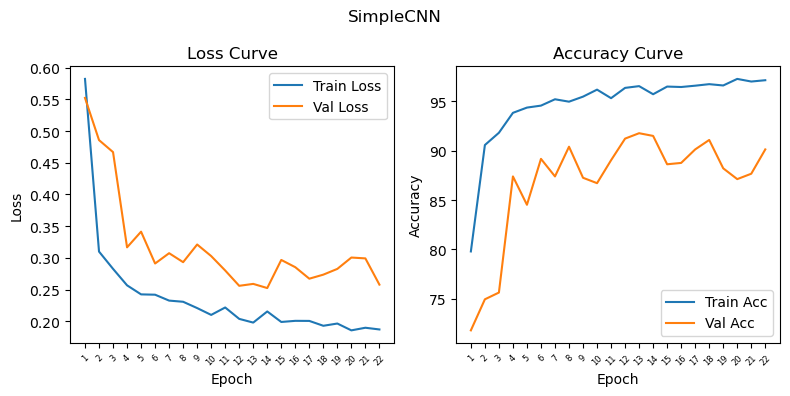

In [44]:
# SimpleCNN ÌïôÏäµ
model_simpleCNN = SimpleCNN(num_classes, dropout_p=0.4).to(device)

optimizer = torch.optim.AdamW(
    model_simpleCNN.parameters(), # Ï†ÑÏ≤¥
    lr=4e-4, weight_decay=6e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=4e-4, steps_per_epoch=len(train_loader), epochs=EPOCHS,
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS+2)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
# )

model_title = "SimpleCNN"
print("="*5, model_title, "="*5)

simpleCNN_info = train_model(
    model_simpleCNN, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS, patience=8, min_delta=2e-3)

#### 3-2) resNet18_Frozen ÌïôÏäµ

- LR 2e-5 -> 7e-5 -> 5e-5 -> 1e-3 -> 5e-4 -> 3e-4
- plateau Ïä§Ï∫êÏ§ÑÎü¨ Ï†ÅÏö© -> OneCycleLR ÏúºÎ°ú Ï†ÑÌôò
- LR ÏöîÎèôÏúºÎ°ú Layer 1~4 Ïùò BatchNorm2D Î†àÏù¥Ïñ¥Ïùò ÌÜµÍ≥ÑÎüâÎèÑ ÎèôÍ≤∞ Ï†ÅÏö©

===== resNet18 (Frozen) =====


Epoch 1/30 | Train Loss: 0.6179 | Train Acc: 69.52% | Val Loss: 0.5693 | Val Acc: 67.12% | LRs: ['1.49e-04'] |  Processing Time: 40.5s | 


Epoch 2/30 | Train Loss: 0.4080 | Train Acc: 90.23% | Val Loss: 0.3697 | Val Acc: 84.79% | LRs: ['2.50e-04'] |  Processing Time: 39.9s | 


Epoch 3/30 | Train Loss: 0.3105 | Train Acc: 92.27% | Val Loss: 0.2426 | Val Acc: 91.64% | LRs: ['3.00e-04'] |  Processing Time: 39.6s | 


Epoch 4/30 | Train Loss: 0.2654 | Train Acc: 93.69% | Val Loss: 0.1996 | Val Acc: 92.60% | LRs: ['2.99e-04'] |  Processing Time: 39.6s | 


Epoch 5/30 | Train Loss: 0.2669 | Train Acc: 93.18% | Val Loss: 0.1808 | Val Acc: 93.56% | LRs: ['2.96e-04'] |  Processing Time: 40.7s | 


Epoch 6/30 | Train Loss: 0.2412 | Train Acc: 94.40% | Val Loss: 0.1846 | Val Acc: 93.01% | LRs: ['2.91e-04'] |  Processing Time: 40.3s | 


Epoch 7/30 | Train Loss: 0.2367 | Train Acc: 94.76% | Val Loss: 0.1682 | Val Acc: 93.97% | LRs: ['2.84e-04'] |  Processing Time: 40.2s | 


Epoch 8/30 | Train Loss: 0.2357 | Train Acc: 94.62% | Val Loss: 0.1506 | Val Acc: 94.66% | LRs: ['2.75e-04'] |  Processing Time: 40.3s | 


Epoch 9/30 | Train Loss: 0.2306 | Train Acc: 95.09% | Val Loss: 0.1473 | Val Acc: 95.07% | LRs: ['2.65e-04'] |  Processing Time: 40.9s | 


Epoch 10/30 | Train Loss: 0.2378 | Train Acc: 94.69% | Val Loss: 0.1342 | Val Acc: 96.30% | LRs: ['2.53e-04'] |  Processing Time: 39.4s | 


Epoch 11/30 | Train Loss: 0.2275 | Train Acc: 95.34% | Val Loss: 0.1352 | Val Acc: 95.62% | LRs: ['2.40e-04'] |  Processing Time: 41.4s | 


Epoch 12/30 | Train Loss: 0.2272 | Train Acc: 95.16% | Val Loss: 0.1356 | Val Acc: 95.48% | LRs: ['2.25e-04'] |  Processing Time: 40.5s | 


Epoch 13/30 | Train Loss: 0.2257 | Train Acc: 95.11% | Val Loss: 0.1342 | Val Acc: 95.62% | LRs: ['2.09e-04'] |  Processing Time: 40.3s | 


Epoch 14/30 | Train Loss: 0.2208 | Train Acc: 95.65% | Val Loss: 0.1367 | Val Acc: 95.48% | LRs: ['1.93e-04'] |  Processing Time: 40.7s | 


Epoch 15/30 | Train Loss: 0.2209 | Train Acc: 95.40% | Val Loss: 0.1342 | Val Acc: 95.75% | LRs: ['1.76e-04'] |  Processing Time: 40.0s | 
Early stopping at epoch 15
Total Learning Time: 0:10:04 (epoch 15) | Best epoch: 10


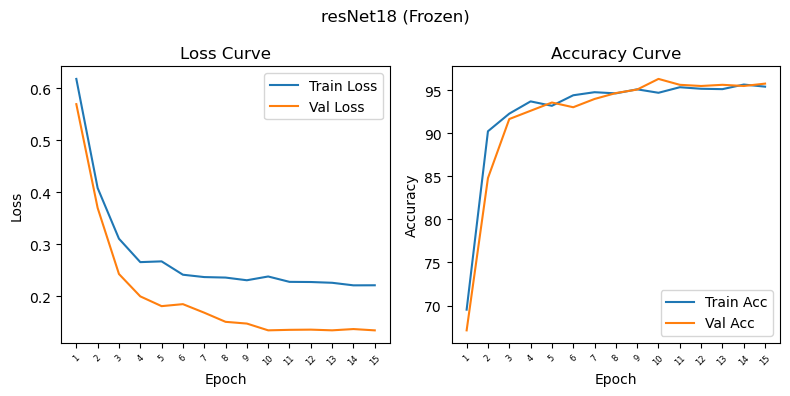

In [45]:
def set_frozen_blocks_eval(m, model_title=None): # BatchNorm2D Î†àÏù¥Ïñ¥Ïùò ÌÜµÍ≥ÑÎüâÎèÑ ÎèôÍ≤∞
    # layer1~3ÏùÄ P ÎèôÍ≤∞
    m.layer1.eval()
    m.layer2.eval()
    m.layer3.eval()
    if model_title == "resNet18 (Frozen)": # 4Îäî FE ÎèôÍ≤∞
        m.layer4.eval()

# resNet18_Frozen
model_resNet18_FE = get_resnet_feature_extraction(num_classes).to(device)

optimizer = torch.optim.AdamW(
    model_resNet18_FE.fc.parameters(), # fcÎßå
    lr=3e-4, weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, total_steps=EPOCHS*len(train_loader),
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.1, patience=2, min_lr=1e-6
# )

model_title = "resNet18 (Frozen)"
print("="*5, model_title, "="*5)

resNet18_FE_info = train_model(
    model_resNet18_FE, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS, patience=5, min_delta=2e-3,
)

#### 3-3) resNet18_Partial ÌïôÏäµ

- l4_params, LR = 3e-6 -> 3e-4 -> 1e-4 -> 5e-5 -> 5e-6 -> 4e-6
- fc_params, LR = 7e-5 -> 5e-4 -> 8e-4 -> 5e-4 -> 5e-4 -> 3e-5
- plateau Ïä§Ï∫êÏ§ÑÎü¨ Ï†ÅÏö© ->OneCycleLR ÏúºÎ°ú Ï†ÑÌôò

===== resNet18 (Partial) =====


Epoch 1/30 | Train Loss: 0.6292 | Train Acc: 64.70% | Val Loss: 0.5408 | Val Acc: 75.89% | LRs: ['1.99e-06', '1.49e-05'] |  Processing Time: 41.4s | 


Epoch 2/30 | Train Loss: 0.4192 | Train Acc: 86.10% | Val Loss: 0.2927 | Val Acc: 92.47% | LRs: ['3.33e-06', '2.50e-05'] |  Processing Time: 41.4s | 


Epoch 3/30 | Train Loss: 0.2906 | Train Acc: 92.09% | Val Loss: 0.1865 | Val Acc: 95.48% | LRs: ['4.00e-06', '3.00e-05'] |  Processing Time: 40.2s | 


Epoch 4/30 | Train Loss: 0.2402 | Train Acc: 94.62% | Val Loss: 0.1523 | Val Acc: 95.34% | LRs: ['3.99e-06', '2.99e-05'] |  Processing Time: 40.4s | 


Epoch 5/30 | Train Loss: 0.2253 | Train Acc: 95.14% | Val Loss: 0.1524 | Val Acc: 94.38% | LRs: ['3.95e-06', '2.96e-05'] |  Processing Time: 40.9s | 


Epoch 6/30 | Train Loss: 0.2112 | Train Acc: 95.94% | Val Loss: 0.1452 | Val Acc: 94.25% | LRs: ['3.88e-06', '2.91e-05'] |  Processing Time: 41.4s | 


Epoch 7/30 | Train Loss: 0.2002 | Train Acc: 96.42% | Val Loss: 0.1518 | Val Acc: 93.97% | LRs: ['3.79e-06', '2.84e-05'] |  Processing Time: 40.3s | 


Epoch 8/30 | Train Loss: 0.2042 | Train Acc: 96.31% | Val Loss: 0.1466 | Val Acc: 94.11% | LRs: ['3.67e-06', '2.75e-05'] |  Processing Time: 40.7s | 


Epoch 9/30 | Train Loss: 0.2011 | Train Acc: 96.42% | Val Loss: 0.1678 | Val Acc: 93.70% | LRs: ['3.53e-06', '2.65e-05'] |  Processing Time: 40.7s | 


Epoch 10/30 | Train Loss: 0.1932 | Train Acc: 96.80% | Val Loss: 0.1447 | Val Acc: 94.38% | LRs: ['3.37e-06', '2.53e-05'] |  Processing Time: 41.2s | 


Epoch 11/30 | Train Loss: 0.1916 | Train Acc: 97.09% | Val Loss: 0.1446 | Val Acc: 94.66% | LRs: ['3.19e-06', '2.40e-05'] |  Processing Time: 41.1s | 


Epoch 12/30 | Train Loss: 0.1899 | Train Acc: 97.18% | Val Loss: 0.1490 | Val Acc: 94.38% | LRs: ['3.00e-06', '2.25e-05'] |  Processing Time: 41.7s | 


Epoch 13/30 | Train Loss: 0.1872 | Train Acc: 97.18% | Val Loss: 0.1663 | Val Acc: 93.42% | LRs: ['2.79e-06', '2.09e-05'] |  Processing Time: 41.2s | 


Epoch 14/30 | Train Loss: 0.1908 | Train Acc: 97.05% | Val Loss: 0.1915 | Val Acc: 92.60% | LRs: ['2.57e-06', '1.93e-05'] |  Processing Time: 40.5s | 
Early stopping at epoch 14
Total Learning Time: 0:09:33 (epoch 14) | Best epoch: 6


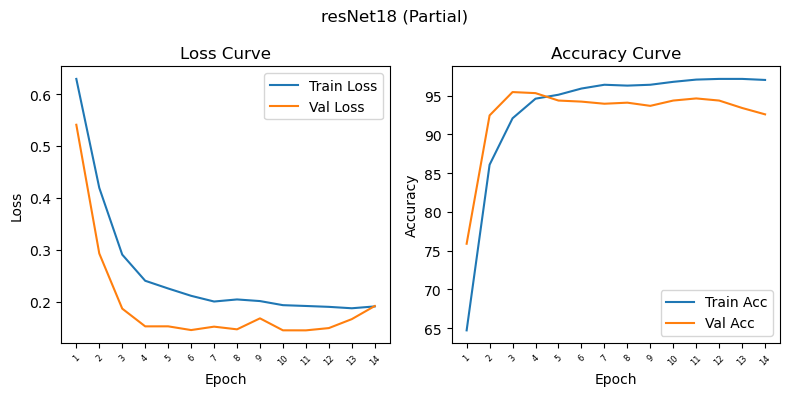

In [53]:
# resNet18_Partial
model_resNet18_P = get_resnet_partial(num_classes, unfreeze_from_layer=4).to(device) # fc ÏßÅÏ†Ñ ÎßàÏßÄÎßâ conv layer

l4_params = [p for p in model_resNet18_P.layer4.parameters() if p.requires_grad]    # layer4 conv
fc_params = [p for p in model_resNet18_P.fc.parameters() if p.requires_grad]        # fc

optimizer = torch.optim.AdamW(
    [
      {"params": l4_params, "lr": 4e-6},
      {"params": fc_params, "lr": 3e-5},
    ],
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=[4e-6, 3e-5], total_steps=EPOCHS*len(train_loader),
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.65, patience=3, min_lr=1e-6
# )

model_title = "resNet18 (Partial)"
print("="*5, model_title, "="*5)

resNet18_P_info = train_model(
    model_resNet18_P, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS, patience=8, min_delta=2e-3,
)

#### 3-4) resNet18_fine-tune ÌïôÏäµ

- ly_params, LR = 1e-5 -> 1e-6
- fc_params, LR = 7e-5 -> 5e-4 -> 8e-4 -> 5e-4 -> 5e-4 -> 3e-5

===== resNet18 (Fine-tuning) =====


Epoch 1/30 | Train Loss: 0.6312 | Train Acc: 65.55% | Val Loss: 0.5888 | Val Acc: 72.47% | LRs: ['5.01e-07', '1.50e-05'] |  Processing Time: 40.6s | 


Epoch 2/30 | Train Loss: 0.5236 | Train Acc: 80.70% | Val Loss: 0.4728 | Val Acc: 83.15% | LRs: ['8.36e-07', '2.51e-05'] |  Processing Time: 41.2s | 


Epoch 3/30 | Train Loss: 0.4102 | Train Acc: 89.25% | Val Loss: 0.3445 | Val Acc: 90.14% | LRs: ['1.00e-06', '3.00e-05'] |  Processing Time: 40.9s | 


Epoch 4/30 | Train Loss: 0.3253 | Train Acc: 92.16% | Val Loss: 0.2734 | Val Acc: 91.23% | LRs: ['9.97e-07', '2.99e-05'] |  Processing Time: 40.4s | 


Epoch 5/30 | Train Loss: 0.2784 | Train Acc: 94.05% | Val Loss: 0.2275 | Val Acc: 92.60% | LRs: ['9.86e-07', '2.96e-05'] |  Processing Time: 40.6s | 


Epoch 6/30 | Train Loss: 0.2670 | Train Acc: 92.89% | Val Loss: 0.2047 | Val Acc: 93.42% | LRs: ['9.70e-07', '2.91e-05'] |  Processing Time: 40.3s | 


Epoch 7/30 | Train Loss: 0.2444 | Train Acc: 93.96% | Val Loss: 0.1959 | Val Acc: 93.15% | LRs: ['9.46e-07', '2.84e-05'] |  Processing Time: 40.8s | 


Epoch 8/30 | Train Loss: 0.2421 | Train Acc: 94.25% | Val Loss: 0.1899 | Val Acc: 93.56% | LRs: ['9.17e-07', '2.75e-05'] |  Processing Time: 39.7s | 


Epoch 9/30 | Train Loss: 0.2191 | Train Acc: 95.47% | Val Loss: 0.1931 | Val Acc: 92.88% | LRs: ['8.83e-07', '2.65e-05'] |  Processing Time: 40.9s | 


Epoch 10/30 | Train Loss: 0.2250 | Train Acc: 95.29% | Val Loss: 0.1837 | Val Acc: 93.42% | LRs: ['8.43e-07', '2.53e-05'] |  Processing Time: 40.6s | 


Epoch 11/30 | Train Loss: 0.2114 | Train Acc: 96.11% | Val Loss: 0.1868 | Val Acc: 93.01% | LRs: ['7.98e-07', '2.39e-05'] |  Processing Time: 40.2s | 


Epoch 12/30 | Train Loss: 0.2105 | Train Acc: 95.98% | Val Loss: 0.1721 | Val Acc: 94.52% | LRs: ['7.49e-07', '2.25e-05'] |  Processing Time: 40.8s | 


Epoch 13/30 | Train Loss: 0.1997 | Train Acc: 96.33% | Val Loss: 0.1677 | Val Acc: 94.52% | LRs: ['6.98e-07', '2.09e-05'] |  Processing Time: 40.6s | 


Epoch 14/30 | Train Loss: 0.2050 | Train Acc: 96.20% | Val Loss: 0.1748 | Val Acc: 93.29% | LRs: ['6.43e-07', '1.93e-05'] |  Processing Time: 41.2s | 


Epoch 15/30 | Train Loss: 0.2023 | Train Acc: 96.56% | Val Loss: 0.1724 | Val Acc: 94.11% | LRs: ['5.86e-07', '1.76e-05'] |  Processing Time: 40.7s | 


Epoch 16/30 | Train Loss: 0.1967 | Train Acc: 96.69% | Val Loss: 0.1809 | Val Acc: 93.29% | LRs: ['5.29e-07', '1.59e-05'] |  Processing Time: 40.4s | 


Epoch 17/30 | Train Loss: 0.1994 | Train Acc: 96.53% | Val Loss: 0.1656 | Val Acc: 94.11% | LRs: ['4.71e-07', '1.41e-05'] |  Processing Time: 40.3s | 


Epoch 18/30 | Train Loss: 0.1995 | Train Acc: 96.18% | Val Loss: 0.1834 | Val Acc: 93.01% | LRs: ['4.13e-07', '1.24e-05'] |  Processing Time: 40.8s | 


Epoch 19/30 | Train Loss: 0.1991 | Train Acc: 96.40% | Val Loss: 0.1902 | Val Acc: 92.47% | LRs: ['3.56e-07', '1.07e-05'] |  Processing Time: 39.5s | 


Epoch 20/30 | Train Loss: 0.1904 | Train Acc: 96.93% | Val Loss: 0.1640 | Val Acc: 94.25% | LRs: ['3.02e-07', '9.05e-06'] |  Processing Time: 41.1s | 


Epoch 21/30 | Train Loss: 0.1971 | Train Acc: 96.76% | Val Loss: 0.1991 | Val Acc: 92.05% | LRs: ['2.50e-07', '7.50e-06'] |  Processing Time: 40.7s | 


Epoch 22/30 | Train Loss: 0.1978 | Train Acc: 96.67% | Val Loss: 0.1924 | Val Acc: 92.47% | LRs: ['2.01e-07', '6.04e-06'] |  Processing Time: 40.0s | 
Early stopping at epoch 22
Total Learning Time: 0:14:52 (epoch 22) | Best epoch: 17


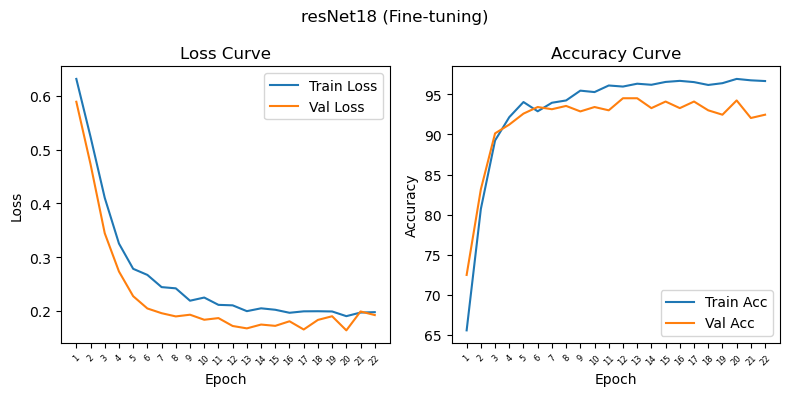

In [25]:
# resNet18_fine-tune
model_resNet18_FT = get_resnet_finetune(num_classes).to(device)

ly_params = [p for n,p in model_resNet18_FT.named_parameters() if "fc" not in n]    # fc ÎπºÍ≥† ÎÇòÎ®∏ÏßÄ
fc_params = [p for p in model_resNet18_FT.fc.parameters()]                          # fc

optimizer = torch.optim.AdamW(
    [
      {"params": ly_params, "lr": 1e-6}, # fc Ï†úÏô∏ ÏïÑÏ£º ÎÇÆÍ≤å ÏÑ§Ï†ï
      {"params": fc_params, "lr": 3e-5},
    ],
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=[1e-6, 3e-5], total_steps=EPOCHS*len(train_loader),
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.3, patience=2, min_lr=1e-6
# )

model_title = "resNet18 (Fine-tuning)"
print("="*5, model_title, "="*5)

resNet18_FT_info = train_model(
    model_resNet18_FT, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS-2, patience=5, min_delta=2e-3,
)

In [26]:
summary(model_resNet18_P, input_size=(batch_size, 3, CROP_SIZE, CROP_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
‚îú‚îÄConv2d: 1-1                            [64, 64, 112, 112]        (9,408)
‚îú‚îÄBatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
‚îú‚îÄReLU: 1-3                              [64, 64, 112, 112]        --
‚îú‚îÄMaxPool2d: 1-4                         [64, 64, 56, 56]          --
‚îú‚îÄSequential: 1-5                        [64, 64, 56, 56]          --
‚îÇ    ‚îî‚îÄBasicBlock: 2-1                   [64, 64, 56, 56]          --
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d: 3-1                  [64, 64, 56, 56]          (36,864)
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
‚îÇ    ‚îÇ    ‚îî‚îÄReLU: 3-3                    [64, 64, 56, 56]          --
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d: 3-4                  [64, 64, 56, 56]          (36,864)
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d: 3-5             [64, 64, 56, 56]         

# 4. ÌèâÍ∞Ä ÏßÄÌëú ÌôïÏù∏


- Ï†ïÌôïÎèÑ, Ï†ïÎ∞ÄÎèÑ, Ïû¨ÌòÑÏú®, F1-Score Îì± Î™®Îç∏Îì§Ïùò Ï†ÑÏ≤¥Ï†ÅÏù∏ ÌèâÍ∞Ä ÏßÄÌëú ÌôïÏù∏

In [54]:
@torch.inference_mode()  # = no_gradÏùò superset(Ï∂îÎ°† ÏµúÏ†ÅÌôî)
def predict_proba(model, dataloader, device, temp_scaler=None, return_loss=False, criterion=None):
    """loader Ï†ÑÏ≤¥Ïóê ÎåÄÌï¥ (y, p1[, loss_mean]) Î∞òÌôò. p1 = class-1 ÌôïÎ•†"""
    model.eval()
    y_all, p_all = [], []
    loss_sum, total = 0.0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        if temp_scaler is not None:
            logits = temp_scaler(logits)
        if return_loss and criterion is not None:
            loss_sum += criterion(logits, y).item() * x.size(0)
            total += y.size(0)

        p1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        y_all.append(y.cpu().numpy()); p_all.append(p1)

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    if return_loss and criterion is not None:
        return y_all, p_all, loss_sum / max(total, 1)
    return y_all, p_all


def apply_threshold(p1, threshold=0.5):
    return (p1 >= threshold).astype(np.int64)


def summarize_metrics(y_true, y_pred, loss_mean=None, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="binary", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="binary", zero_division=0)

    print("\n", "="*15, model_name, "="*15)
    print(f"üìä Classification Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"], zero_division=0))
    if loss_mean is not None:
        print(f"‚úÖ Loss: {loss_mean:.4f}")
    print(f"‚úÖ Accuracy: {acc:.2%}")
    print(f"‚úÖ Precision: {prec:.4f}")
    print(f"‚úÖ Recall: {rec:.4f}")
    print(f"‚úÖ F1-score: {f1:.4f}", "\n")
    return acc, prec, rec, f1

In [55]:
@torch.inference_mode()  # = no_gradÏùò superset(Ï∂îÎ°† ÏµúÏ†ÅÌôî)
def evaluate_model(model, dataloader, criterion, device, model_name="Model",
                   threshold=0.5, temp_scaler=None, verbose=True):
    y_true, p1, loss_mean = predict_proba(
        model, dataloader, device, temp_scaler=temp_scaler,
        return_loss=(criterion is not None), criterion=criterion
    )
    y_pred = apply_threshold(p1, threshold)
    if verbose:
        return (*summarize_metrics(y_true, y_pred, loss_mean, model_name), y_true, y_pred)
    else:
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        return acc, prec, rec, f1, y_true, y_pred

## 4-1. Í≤ÄÏ¶ù(val) Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌèâÍ∞Ä ÏßÄÌëú ÌôïÏù∏ (Ï∞∏Í≥†Ïö©)


 =============== SimpleCNN ===============
üìä Classification Report for SimpleCNN
              precision    recall  f1-score   support

      Normal       0.98      0.79      0.88       276
   Pneumonia       0.89      0.99      0.94       454

    accuracy                           0.92       730
   macro avg       0.93      0.89      0.91       730
weighted avg       0.92      0.92      0.91       730

‚úÖ Loss: 0.2524
‚úÖ Accuracy: 91.51%
‚úÖ Precision: 0.8874
‚úÖ Recall: 0.9890
‚úÖ F1-score: 0.9354 


 =============== resNet18 (Frozen) ===============
üìä Classification Report for resNet18 (Frozen)
              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       276
   Pneumonia       0.98      0.96      0.97       454

    accuracy                           0.96       730
   macro avg       0.96      0.96      0.96       730
weighted avg       0.96      0.96      0.96       730

‚úÖ Loss: 0.1342
‚úÖ Accuracy: 96.30%
‚úÖ Precision: 0.977

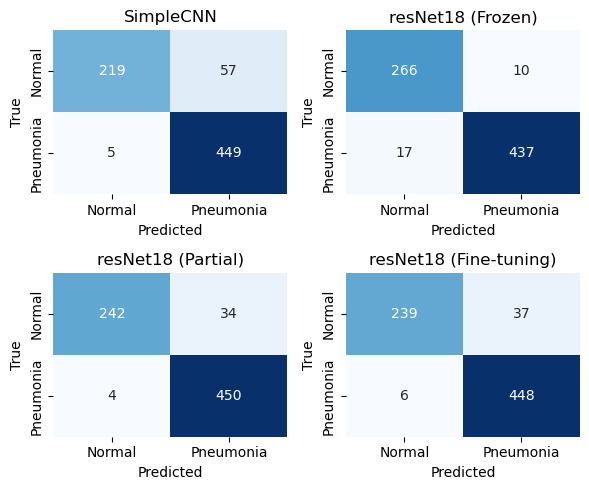

In [46]:
# valÎ°ú ÌôïÏù∏
models_to_val = {
    simpleCNN_info["model_title"]: model_simpleCNN,
    resNet18_FE_info["model_title"] : model_resNet18_FE,
    resNet18_P_info["model_title"] : model_resNet18_P,
    resNet18_FT_info["model_title"] : model_resNet18_FT
}

results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
cm_data = {}

criterion = torch.nn.CrossEntropyLoss()

for model_name, model in models_to_val.items():
    acc, prec, rec, f1, y_true, y_pred = evaluate_model(
        model, val_loader, criterion, device, model_name, threshold=0.5
    )
    results["Model"].append(model_name)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1-score"].append(f1)
    cm_data[model_name] = (y_true, y_pred)

df_val_results = pd.DataFrame(results)

# ÌïôÏäµ ÏÜåÏöî ÏãúÍ∞Ñ Ï∂îÍ∞Ä
df_val_results["Learning Time"] =  [simpleCNN_info["elapsed"],
                                resNet18_FE_info["elapsed"],
                                resNet18_P_info["elapsed"],
                                resNet18_FT_info["elapsed"]
    ]

print("\n", "="*35, "Val Score", "="*35)
display(df_val_results.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}"
}))

# ÌòºÎèôÌñâÎ†¨
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.ravel()

for ax, (model_name, _) in zip(axes, models_to_val.items()):
    y_true, y_pred = cm_data[model_name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"],
                ax=ax, cbar=False)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout()
plt.show()

## 4-2. Threshold Ï∞æÍ∏∞
- Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú f1Ïä§ÏΩîÏñ¥Î•º ÎÜíÏù¥Í∏∞ ÏúÑÌïú Î∞©Î≤ïÏùÑ Í≥†ÎØº
- Í∏∞Î≥∏Í∞í 0.5Í∞Ä ÏïÑÎãå Í∞Å Î™®Îç∏Ïùò f1 Ïä§ÏΩîÏñ¥Ïùò ÏûÑÍ≥ÑÍ∞íÏùÑ Ï∞æÏïÑÏÑú Ï†ÅÏö©
- Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú `ÏµúÏ†ÅÏùò ÏûÑÍ≥ÑÍ∞í` (Threshold) ÏùÑ Ï∞æÏïÑ ÌÖåÏä§Ìä∏ ÏÖãÏóê Ï†ÅÏö©ÌïòÎäî Í≤ÉÏúºÎ°ú ÏßÑÌñâ

In [56]:
@torch.inference_mode()
def find_best_threshold(model, val_loader, device, target='f1', prec_target=0.85, temp_scaler=None):
    model.eval()
    y, p = predict_proba(model, val_loader, device, temp_scaler=temp_scaler)

    if target == 'f1':
        ts = np.linspace(0.1, 0.9, 81)
        f1s = [f1_score(y, (p >= t).astype(int)) for t in ts]
        return float(ts[int(np.argmax(f1s))])
    else:
        # Ï†ïÎ∞ÄÎèÑ(precision) >= prec_targetÏóêÏÑú Ïû¨ÌòÑÏú® ÏµúÎåÄÍ∞Ä ÎêòÎäî ÏûÑÍ≥ÑÍ∞í
        prec, rec, ts = precision_recall_curve(y, p)
        mask = prec[:-1] >= prec_target
        return float(ts[mask][np.argmax(rec[:-1][mask])]) if mask.any() else 0.5

In [57]:
# Í∞Å Î™®Îç∏Î≥ÑÎ°ú threshold
thresholds = {}
for name, model in models_to_val.items():
    t_star = find_best_threshold(model, val_loader, device, target='f1')
    thresholds[name] = t_star
    print(f"[{name}] best threshold on val = {t_star:.3f}")

[SimpleCNN] best threshold on val = 0.690
[resNet18 (Frozen)] best threshold on val = 0.490
[resNet18 (Partial)] best threshold on val = 0.610
[resNet18 (Fine-tuning)] best threshold on val = 0.640


## 4-3. ÌÖåÏä§Ìä∏(test) Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Threshold Ï†ÅÏö© Î∞è ÏßÄÌëú ÌôïÏù∏
- threshold Í∞íÏùÑ Ï†ÅÏö©ÌïòÏßÄ ÏïäÏùÄ testÏÖãÍ≥º Ï†ÅÏö©Ìïú testÏÖã Í≤∞Í≥º ÏßÄÌëú ÎπÑÍµê


 =============== SimpleCNN ===============
üìä Classification Report for SimpleCNN
              precision    recall  f1-score   support

      Normal       0.94      0.19      0.31       234
   Pneumonia       0.67      0.99      0.80       390

    accuracy                           0.69       624
   macro avg       0.80      0.59      0.56       624
weighted avg       0.77      0.69      0.62       624

‚úÖ Loss: 0.7492
‚úÖ Accuracy: 69.07%
‚úÖ Precision: 0.6707
‚úÖ Recall: 0.9923
‚úÖ F1-score: 0.8004 


 =============== resNet18 (Frozen) ===============
üìä Classification Report for resNet18 (Frozen)
              precision    recall  f1-score   support

      Normal       0.95      0.52      0.67       234
   Pneumonia       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624

‚úÖ Loss: 0.4117
‚úÖ Accuracy: 80.77%
‚úÖ Precision: 0.772

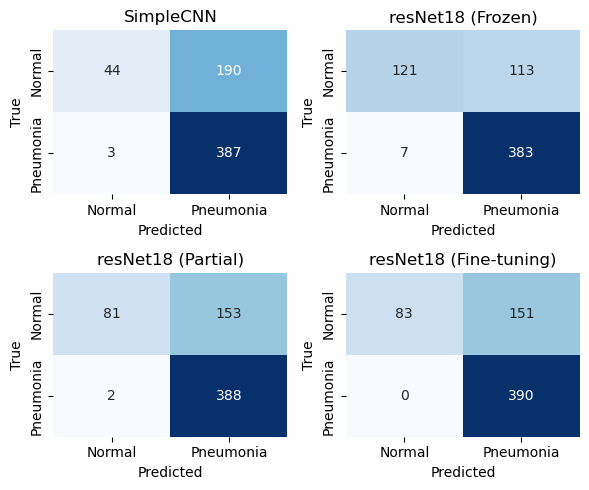

In [58]:
# testÎ°ú ÌôïÏù∏ (Threshold Ï†ÅÏö©X)
models_to_test = models_to_val

test_results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
cm_test_base = {}

for model_name, model in models_to_test.items():
    acc, prec, rec, f1, y_true, y_pred = evaluate_model(
        model, test_loader, criterion, device, model_name, threshold=0.5
    )
    test_results["Model"].append(model_name)
    test_results["Accuracy"].append(acc)
    test_results["Precision"].append(prec)
    test_results["Recall"].append(rec)
    test_results["F1-score"].append(f1)
    cm_test_base[model_name] = (y_true, y_pred)

df_test_results = pd.DataFrame(test_results)

print("\n", "="*35, "Test Score", "="*35)
display(df_test_results.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}"
}))

# ÌòºÎèôÌñâÎ†¨
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.ravel()

for ax, (model_name, _) in zip(axes, models_to_test.items()):
    y_true, y_pred = cm_test_base[model_name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"],
                ax=ax, cbar=False)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout()
plt.show()


>>> Testing [SimpleCNN] with threshold = 0.690

 =============== SimpleCNN @ t=0.690 ===============
üìä Classification Report for SimpleCNN @ t=0.690
              precision    recall  f1-score   support

      Normal       0.93      0.29      0.45       234
   Pneumonia       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.63       624
weighted avg       0.79      0.73      0.68       624

‚úÖ Loss: 0.7492
‚úÖ Accuracy: 72.76%
‚úÖ Precision: 0.7000
‚úÖ Recall: 0.9872
‚úÖ F1-score: 0.8191 


>>> Testing [resNet18 (Frozen)] with threshold = 0.490

 =============== resNet18 (Frozen) @ t=0.490 ===============
üìä Classification Report for resNet18 (Frozen) @ t=0.490
              precision    recall  f1-score   support

      Normal       0.94      0.51      0.66       234
   Pneumonia       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.86

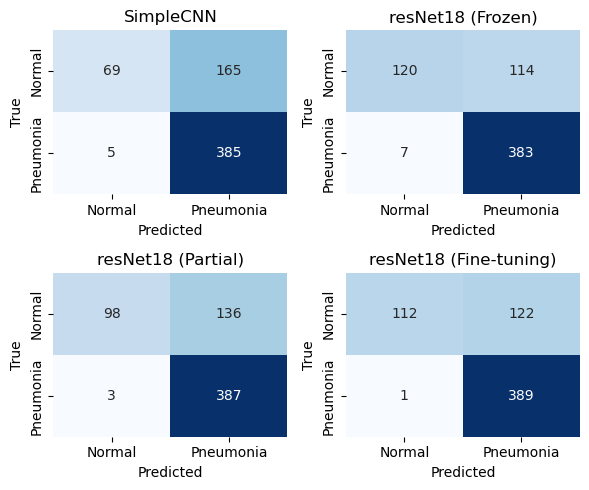

In [59]:
models_to_test_with_threshold = models_to_val  # ÎèôÏùºÌïú dict Ïû¨ÏÇ¨Ïö©

test_with_threshold_results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
cm_test_with_threshold = {}

for name, model in models_to_test_with_threshold.items():
    t = float(thresholds.get(name, 0.5))
    print(f"\n>>> Testing [{name}] with threshold = {t:.3f}")
    acc, prec, rec, f1, y_true, y_pred = evaluate_model(
        model=model,
        dataloader=test_loader,
        criterion=criterion,
        device=device,
        model_name=f"{name} @ t={t:.3f}",
        threshold=t,
    )
    test_with_threshold_results["Model"].append(name)
    test_with_threshold_results["Accuracy"].append(acc)
    test_with_threshold_results["Precision"].append(prec)
    test_with_threshold_results["Recall"].append(rec)
    test_with_threshold_results["F1-score"].append(f1)
    cm_test_with_threshold[name] = (y_true, y_pred)

df_test_with_threshold = pd.DataFrame(test_with_threshold_results)
print("\n", "="*25, "Test Score (tuned thresholds)", "="*25)
display(df_test_with_threshold.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}"
}))

fig, axes = plt.subplots(2, 2, figsize=(6, 5))  # Î™®Îç∏ 4Í∞ú Í∏∞Ï§Ä
axes = axes.ravel()
for ax, (name, _) in zip(axes, models_to_test_with_threshold.items()):
    y_true, y_pred = cm_test_with_threshold[name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"],
                ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

In [62]:
df_test_with_threshold = df_test_with_threshold.copy()
df_test_with_threshold["Threshold"] = df_test_with_threshold["Model"].map(thresholds)

left  = df_test_results.rename(columns={
    "Accuracy":"Accuracy (0.5)", "Precision":"Precision (0.5)", "Recall":"Recall (0.5)", "F1-score":"F1 (0.5)"
})
right = df_test_with_threshold.rename(columns={
    "Accuracy":"Accuracy (tuned)", "Precision":"Precision (tuned)", "Recall":"Recall (tuned)", "F1-score":"F1 (tuned)"
})

compare = left.merge(right[["Model","Threshold","Accuracy (tuned)","Precision (tuned)","Recall (tuned)","F1 (tuned)"]],
                     on="Model", how="inner")

for m in ["Accuracy","Precision","Recall","F1"]:
    compare[f"{m} Œî"] = compare[f"{m} (tuned)"] - compare[f"{m} (0.5)"]

compare = compare.sort_values("F1 (tuned)", ascending=False)

display(compare.style.format({
    "Accuracy (0.5)":"{:.2%}", "Accuracy (tuned)":"{:.2%}", "Accuracy Œî":"{:+.2%}",
    "Precision (0.5)":"{:.4f}", "Precision (tuned)":"{:.4f}", "Precision Œî":"{:+.4f}",
    "Recall (0.5)":"{:.4f}", "Recall (tuned)":"{:.4f}", "Recall Œî":"{:+.4f}",
    "F1 (0.5)":"{:.4f}", "F1 (tuned)":"{:.4f}", "F1 Œî":"{:+.4f}"
}))

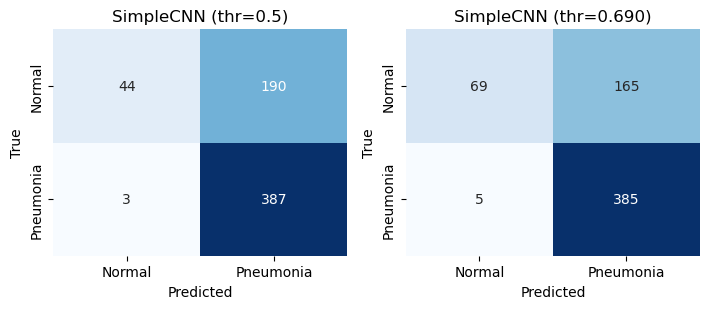

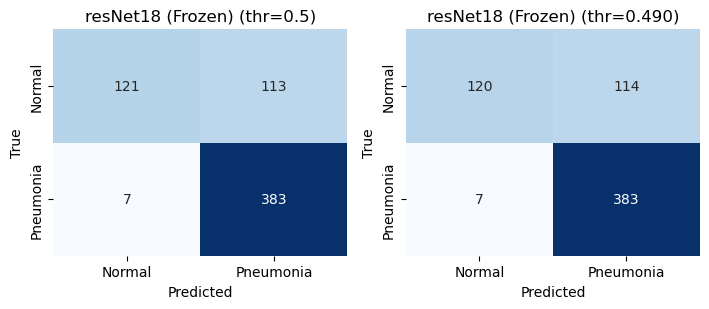

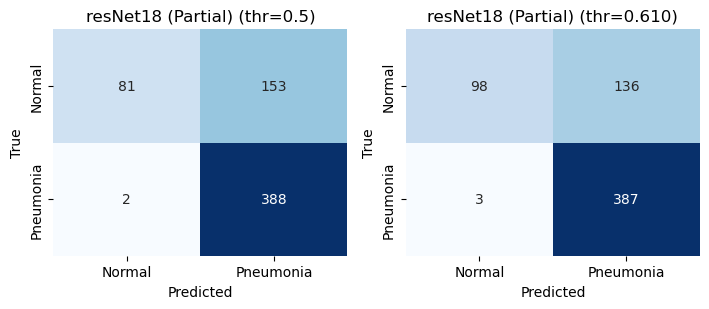

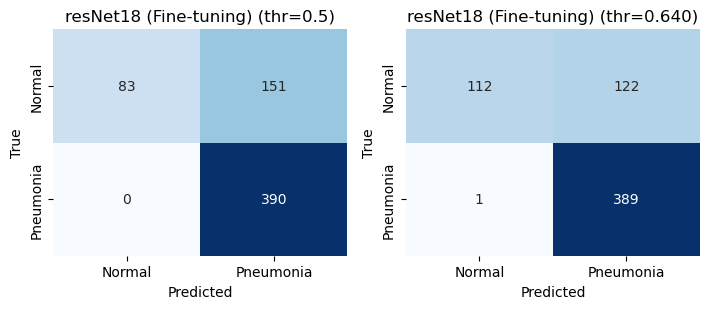

In [63]:
def plot_cm_pair(model_name):
    y_true0, y_pred0 = cm_test_base[model_name]
    y_true1, y_pred1 = cm_test_with_threshold[model_name]

    cm0 = confusion_matrix(y_true0, y_pred0)
    cm1 = confusion_matrix(y_true1, y_pred1)

    fig, axes = plt.subplots(1, 2, figsize=(7.2, 3.2))
    for ax, cm, title in zip(
        axes,
        [cm0, cm1],
        [f"{model_name} (thr=0.5)", f"{model_name} (thr={thresholds[model_name]:.3f})"]
    ):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Normal","Pneumonia"], yticklabels=["Normal","Pneumonia"],
                    cbar=False, ax=ax)
        ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); plt.show()

for name in models_to_test_with_threshold.keys():
    plot_cm_pair(name)

# 5. Í≤∞Í≥º ÏöîÏïΩ

## ÏµúÏ¢Ö F1 Í∏∞Ï§Ä ÏàúÏúÑ(ÌäúÎãù ÏûÑÍ≥ÑÍ∞í Ï†ÅÏö©)
| Rank | Model                    | F1 (tuned) |
|-----:|--------------------------|-----------:|
| 1    | resNet18 (Frozen)        | **0.8636** |
| 2    | resNet18 (Fine-tuning)   | 0.8635     |
| 3    | resNet18 (Partial)       | 0.8478     |
| 4    | SimpleCNN                | 0.8191     |

‚Üí FrozenÏù¥ Í∑ºÏÜåÌïòÍ≤å 1ÏúÑ, Fine-tuningÏù¥ ÏÇ¨Ïã§ÏÉÅ ÎèôÍ∏â ÏÑ±Îä•.

## ÏûÑÍ≥ÑÍ∞í ÌäúÎãù Ìö®Í≥º (ValÏóêÏÑú F1 ÏµúÎåÄÌôî ‚Üí Test Ï†ÅÏö©)
- **Ï†ÑÎ∞òÏ†Å Í≤ΩÌñ•:** Ï†ïÎ∞ÄÎèÑ(Precision) ‚Üë, Ïû¨ÌòÑÏú®(Recall) ÏïΩÍ∞Ñ ‚Üì
- **SimpleCNN:** Acc **+3.69%p**, Prec **+0.0293**, Rec **‚àí0.0051**, F1 **+0.0187**
- **Partial:** Acc **+2.56%p**, Prec **+0.0228**, Rec **‚àí0.0026**, F1 **+0.0142**
- **Fine-tuning:** Acc **+4.49%p**, Prec **+0.0404**, Rec **‚àí0.0026**, F1 **+0.0257**
- **Frozen:** Í±∞Ïùò Î≥ÄÌôî ÏóÜÏùå *(ÏûÑÍ≥ÑÍ∞í 0.49Î°ú ÎØ∏ÏÑ∏ Ï°∞Ï†ï)*

## Ïò§Î∂ÑÎ•ò Ìå®ÌÑ¥ (ÌòºÎèôÌñâÎ†¨ Í∏∞Î∞ò ÌäπÏù¥ÎèÑ Î≥ÄÌôî: TN/(TN+FP))
| Model                  | Before | After | Œî(pp) |
|------------------------|-------:|------:|------:|
| SimpleCNN              | 18.8%  | **29.5%** | **+10.7** |
| resNet18 (Partial)     | 34.6%  | **41.9%** | **+7.3**  |
| resNet18 (Fine-tuning) | 35.5%  | **47.9%** | **+12.4** |
| resNet18 (Frozen)      | 51.7%  | 51.3% | ‚àí0.4  |

‚Üí Î™©ÌëúÏòÄÎçò **False Positive Í∞êÏÜå(ÌäπÏù¥ÎèÑ Í∞úÏÑ†)** Í∞Ä SimpleCNN/Partial/Fine-tuningÏóêÏÑú ÎöúÎ†∑. FrozenÏùÄ Í∏∞Î≥∏ ÌäπÏù¥ÎèÑÍ∞Ä ÎÜíÏïÑ Î≥ÄÌôîÍ∞Ä ÎØ∏ÎØ∏.

## Ïã§Ìóò/Î∂ÑÏÑù Î©îÎ™®
- ÎÜíÏùÄ LRÏóêÏÑú **val loss Ïä§ÌååÏù¥ÌÅ¨** Î∞úÏÉù ‚Üí *warmup*, *ReduceLROnPlateau*, *OneCycleLR* Îì± Ïä§ÏºÄÏ§ÑÎßÅ ÏãúÎèÑ.
- **BatchNorm2dÏùò running statsÎäî `requires_grad=False`ÎßåÏúºÎ°† Í≥†Ï†ïÎêòÏßÄ ÏïäÏùå** ÌôïÏù∏  
  ‚Üí ÎèôÍ≤∞ Î∏îÎ°ùÏóê **`.eval()` Í∞ïÏ†ú Ï†ÅÏö©**(Ïòà: layer1~3 / ÌïÑÏöî Ïãú layer4)ÏúºÎ°ú BN ÌÜµÍ≥Ñ ÏóÖÎç∞Ïù¥Ìä∏ Ï∞®Îã® ‚Üí Ïä§ÌååÏù¥ÌÅ¨ ÏôÑÌôî.
- Í∏∞Î≥∏ ÏûÑÍ≥ÑÍ∞í 0.5ÏóêÏÑúÎäî **ÌäπÏù¥ÎèÑ‚Üì(FP ÎßéÏùå)** Í≤ΩÌñ• ‚Üí **Î™®Îç∏Î≥Ñ ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í** Ï†ÅÏö©ÏúºÎ°ú Í∞úÏÑ†.